## QAOA for Subset_Sum Problem

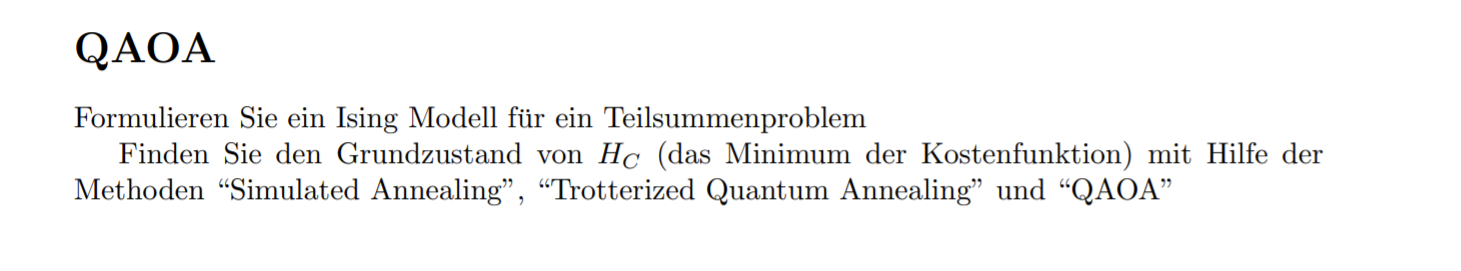

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import seaborn as sns
import random

from dwave_qbsolv import QBSolv

import dimod
import neal
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler

import dimod.utilities

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit.aqua.operators import EvolvedOp
from qiskit.opflow import CircuitOp
from qiskit.optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
import numpy as np
from qiskit.optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Operator

from scipy.optimize import minimize

In [4]:
#easy
number_set = [1, 2, 5, 7]
S = 3

n_qubits = len(number_set)

In [5]:
def fill_QUBO(number_set, S):
    n = len(number_set)
    QUBO = np.zeros((n, n))
    
    #Lin Terms
    for i in range(n):
        w_i = number_set[i]
        QUBO[i][i] = w_i*w_i-2*S*w_i
        #print(w_i*w_i-2*S*w_i)
        
        #Quadratische Terms
        for j in range(i+1, n, 1):
            w_j = number_set[j]
            QUBO[i][j] = 2*w_i*w_j
    return QUBO

In [6]:
QUBO = fill_QUBO(number_set, S)
print(QUBO)

[[-5.  4. 10. 14.]
 [ 0. -8. 20. 28.]
 [ 0.  0. -5. 70.]
 [ 0.  0.  0.  7.]]


## Lösung mit QBSolve (Simulated Annealing)

In [9]:
#QBSolve
def on_QBsolve(qubo_dictionary):
    result = QBSolv().sample_qubo(qubo_dictionary)
    return result


## convert QUBO to dictionary 
qubo_d = {}
x1 = 0
while x1 < n_qubits:
    x2 = x1
    while x2 < n_qubits:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1

In [10]:
on_QBsolve(qubo_d)

SampleSet(rec.array([([1, 1, 0, 0], -9., 51)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i4')]), Variables([0, 1, 2, 3]), {}, 'BINARY')

## Lösung mit DWave (DWave Advantage)

In [10]:
#echtes HW
def on_DWave(QUBO, numr): 
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
    sampler = EmbeddingComposite(DWaveSampler())
       
    # reding num_reads responses from the sampler
    sampleset = sampler.sample(bqm, chain_strength=find_chstr(QUBO),num_reads=numr)
    return sampleset

#Find the Chain Strength following D Waves Problem Solving Handbook
def find_chstr(QUBO):
    chstr = QUBO.max() # Implementation parameter on the DWave QPU
    return chstr;

In [11]:
on_DWave(QUBO, 100)

<ipython-input-10-ebac1c19ccb7>:3: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0, use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)


SampleSet(rec.array([([1, 0], -1., 95, 0.), ([0, 0],  0.,  5, 0.)],
          dtype=[('sample', 'i1', (2,)), ('energy', '<f8'), ('num_occurrences', '<i4'), ('chain_break_fraction', '<f8')]), Variables([0, 1]), {'timing': {'qpu_sampling_time': 8710.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 46.56, 'qpu_access_time': 17157.4, 'qpu_access_overhead_time': 11474.6, 'qpu_programming_time': 8447.4, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 1203.0, 'post_processing_overhead_time': 1203.0}, 'problem_id': '30cee603-83f6-4898-b816-02d8566c9ac4'}, 'BINARY')

## Lösung mit QAOA (Qiskits QuadraticProgram)

In [13]:
qubo = QuadraticProgram()

N = len(QUBO)
for i in range(N):
   l='x'+str(i)
   qubo.binary_var(l)

quad2={}
for i in range(N):
    li='x'+str(i)
    for j in range(N):
        lj='x'+str(j)
        quad2.update({(li, lj): QUBO[i,j]})
qubo.minimize(quadratic=quad2)
print(qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 10 x0^2 + 8 x0*x1 + 20 x0*x2 + 28 x0*x3 - 16 x1^2 + 40 x1*x2
      + 56 x1*x3 - 10 x2^2 + 140 x2*x3 + 14 x3^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



In [14]:
H, offset = qubo.to_ising()
print('offset: {}'.format(offset))
print('S^2', S*S)
print('operator:')
print(H)

offset: 31.0
S^2 9
operator:
SummedOp([
  -4.5 * IIIZ,
  IIZZ,
  -9.0 * IIZI,
  2.5 * IZIZ,
  -22.5 * IZII,
  5.0 * IZZI,
  3.5 * ZIIZ,
  -31.5 * ZIII,
  7.0 * ZIZI,
  17.5 * ZZII
])


In [19]:
# Run quantum algorithm QAOA on qasm simulator
#optimizer = SPSA(maxiter=250)
optimizer = COBYLA(maxiter=250)
backend = Aer.get_backend('qasm_simulator')
qaoa = QAOA(optimizer=optimizer, quantum_instance=backend)
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
print(result)


optimal function value: -9.0
optimal value: [1. 1. 0. 0.]
status: SUCCESS


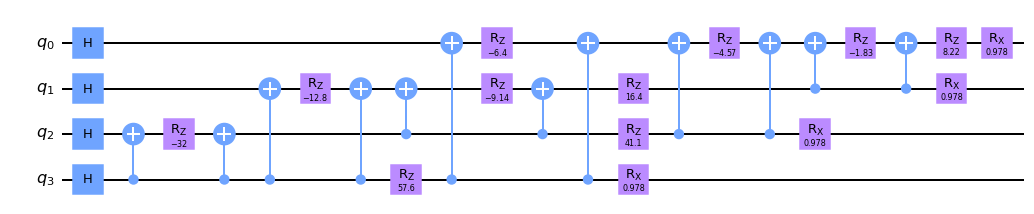

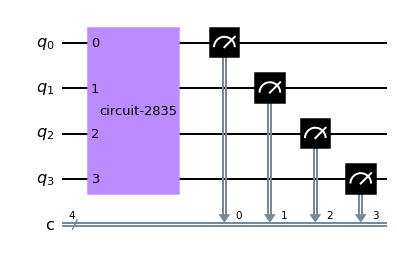

In [20]:
qc = qaoa.get_optimal_circuit()
display(qc.draw('mpl'))
gate = qc.to_gate() 

wires = range(n_qubits)

qc_qaoa = QuantumCircuit(n_qubits, n_qubits)
qc_qaoa.append(gate, wires)
qc_qaoa.measure(wires, wires)
display(qc_qaoa.draw('mpl'))

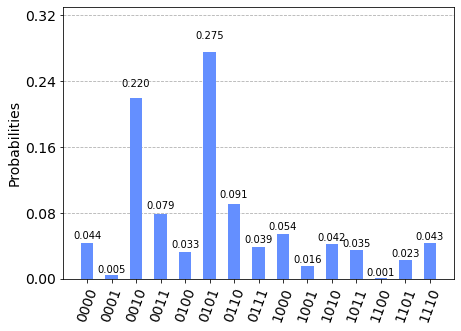

In [21]:
shots = 1000
job = execute(qc_qaoa, backend, shots = shots)
plot_histogram(job.result().get_counts(qc_qaoa))

-------------------

## Aus Qiskit Tutorial 
https://qiskit.org/textbook/ch-applications/qaoa.html

In [27]:
## convert QUBO to dictionary 
n = len(number_set)

qubo_d = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1
print(qubo_d)

isingX = dimod.qubo_to_ising(qubo_d, 0)

print(isingX)
(linear, quadratic, _) = isingX
print("\n Linear:")
print(linear)
print("\n Quadratic:")
print(quadratic)

{(0, 0): -5, (0, 1): 4, (0, 2): 10, (0, 3): 14, (1, 1): -8, (1, 2): 20, (1, 3): 28, (2, 2): -5, (2, 3): 70, (3, 3): 7}
({0: 4.5, 1: 9.0, 2: 22.5, 3: 31.5}, {(0, 1): 1.0, (0, 2): 2.5, (0, 3): 3.5, (1, 2): 5.0, (1, 3): 7.0, (2, 3): 17.5}, 31.0)

 Linear:
{0: 4.5, 1: 9.0, 2: 22.5, 3: 31.5}

 Quadratic:
{(0, 1): 1.0, (0, 2): 2.5, (0, 3): 3.5, (1, 2): 5.0, (1, 3): 7.0, (2, 3): 17.5}


In [28]:
def obj_f(x, QUBO):
    """        
    Returns:
        obj: float
             Objective
    """
    vector = np.unpackbits(np.array([int(x,2)], dtype=np.uint8))
    vector = np.asmatrix(vector[4:]) 
    obj = QUBO*vector.transpose()
    return np.sum(obj)

def compute_expectation(counts, QUBO):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
        
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = obj_f(bitstring, QUBO)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta,n):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = n
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        # problem unitary
        for i in range(n_qubits):
            for j in range(n_qubits):
                if (i, j) in quadratic:
                    qc.rzz(2*beta[irep]*quadratic[(i, j)], i, j)
                    qc.barrier
        
       
         # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2*gamma[irep]*linear[i], i)
            
    qc.measure_all()
    #display(qc.draw('mpl'))    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, n_qubits, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,n_qubits)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        return compute_expectation(counts, QUBO)
    
    return execute_circ

In [29]:
from scipy.optimize import minimize


expectation = get_expectation(p=1, n_qubits = n_qubits)

res = minimize(expectation, [1.0, 1.0, 1.0, 1.0,1.0, 1.0,1.0, 1.0],  method='COBYLA')
res

     fun: 62.7470703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 94
  status: 1
 success: True
       x: array([1.99544588, 1.98173483, 1.99735313, 1.03864831, 1.01329835,
       1.03253355, 1.01212868, 1.01790838])

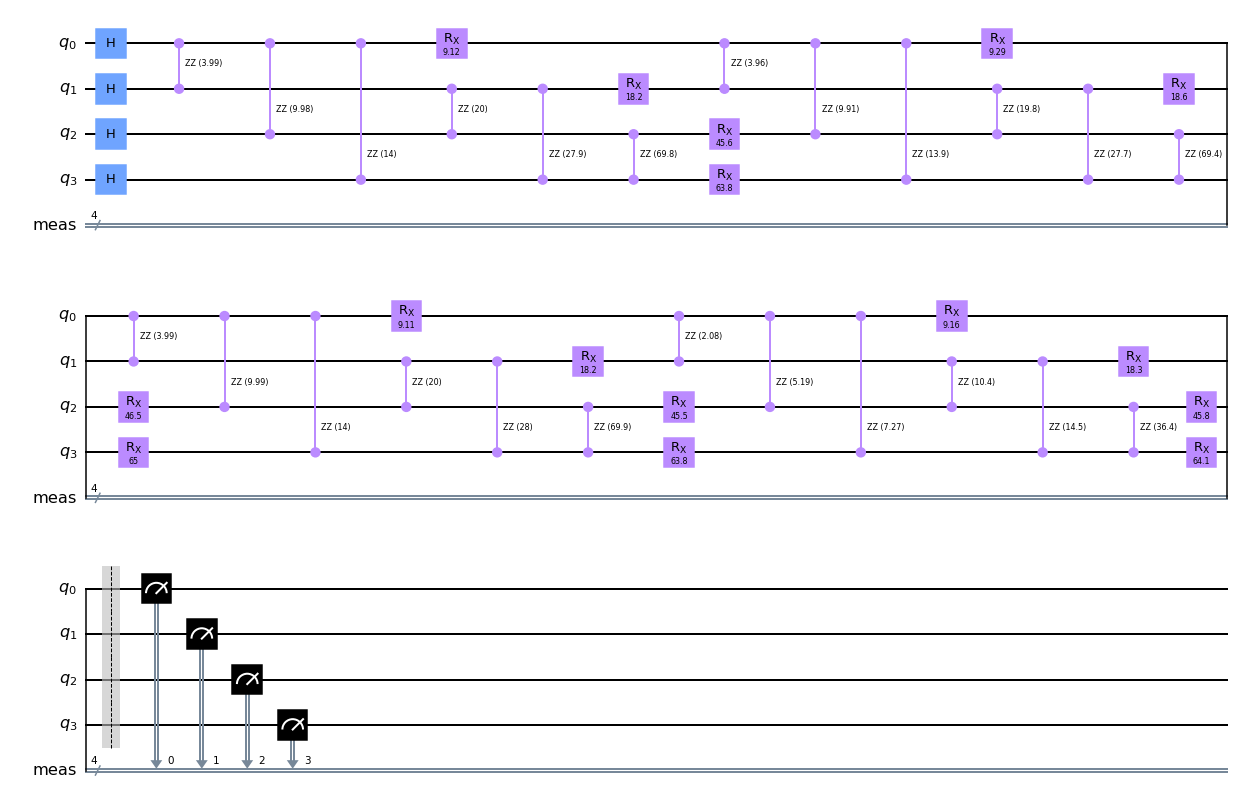

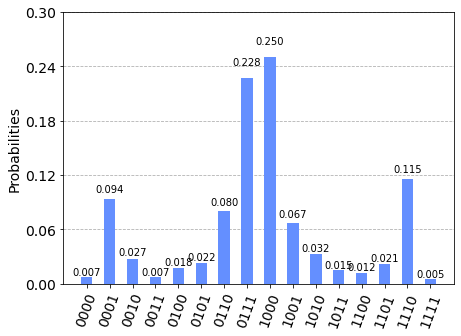

In [41]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,n)
display(qc_res.draw('mpl'))
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

-----------

## PannyLane Zeug

In [43]:
from pennylane import qaoa

In [44]:
wires = range(n_qubits)
depthX = 2

In [45]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)
print(cost_h)

  (4.5) [Z0]
+ (9.0) [Z1]
+ (22.5) [Z2]
+ (31.5) [Z3]
+ (1.0) [Z0 Z1]
+ (2.5) [Z0 Z2]
+ (3.5) [Z0 Z3]
+ (5.0) [Z1 Z2]
+ (7.0) [Z1 Z3]
+ (17.5) [Z2 Z3]


In [46]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [47]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [48]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [49]:
token = '1c854f9916477c15b8ef30c1243313b67e739cfc30f10cd741d7ad787f102bca0f0e60f474acc939c10761884cc75eff19910dbc5fb2e045c1f56dc1b274d553'
dev = qml.device("qiskit.ibmq", wires=wires, ibmqx_token=token)

In [50]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [51]:
optimizer = qml.AdamOptimizer() # qml.GradientDescentOptimizer() # qml.AdamOptimizer() # qml.AdagradOptimizer()

In [52]:
params = [[1.5, 1.5],[1.5, 1.5]] #pre-optimized parameters

print("Start parameters: ", params)

Start parameters:  [[1.5, 1.5], [1.5, 1.5]]


In [53]:
steps = 2

optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"\{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10
C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\AdamOptimizer_2_2_[[1.5, 1.5], [1.5, 1.5]]


In [54]:
for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)
    f = open(savestring + "paramsQuicksaveIBM.txt", 'a+')
    f.write("parameter quicksave stepnumber " + str(i) + ": " + str(params) + "\n\n")
    f.close()

print("\n")
print("Optimal parameters: ", params)

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

 | New parameters: [[1.490000000007026, 1.4900000000006624], [1.509999999984, 1.5099999999888076]]


N/A% (0 of 2) |                          | Elapsed Time: 0:04:30 ETA:  --:--:--


 57
 | New parameters: [[1.4861346890062965, 1.4832917521193052], [1.5163974253460757, 1.5187500284859132]]


 50% (1 of 2) |#############             | Elapsed Time: 0:09:14 ETA:   0:04:43


 114


100% (2 of 2) |##########################| Elapsed Time: 0:09:14 Time:  0:09:14




Optimal parameters:  [[1.4861346890062965, 1.4832917521193052], [1.5163974253460757, 1.5187500284859132]]


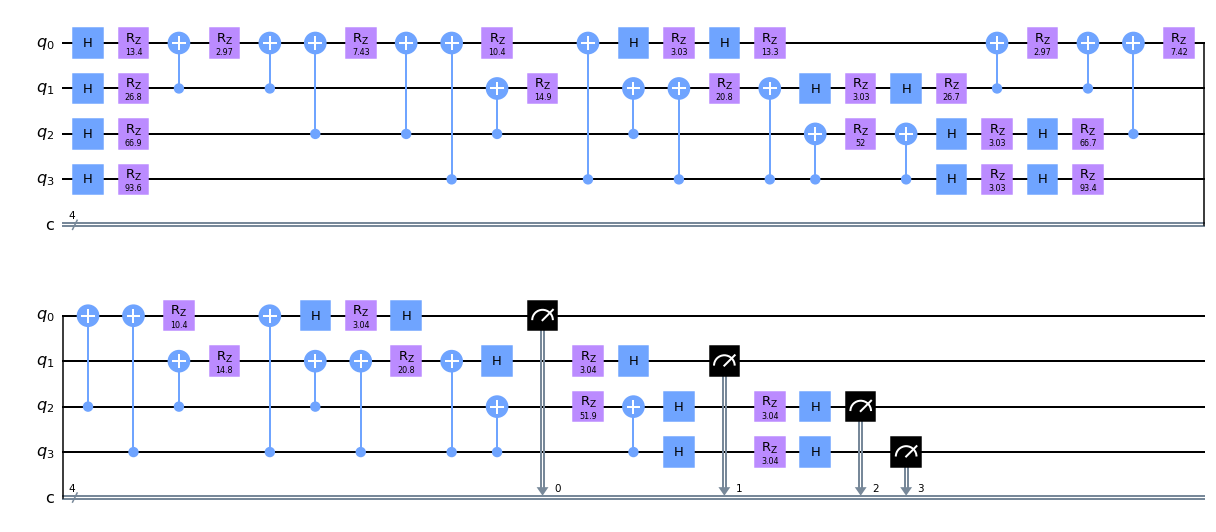

In [55]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    drawer = qml.draw(circuit)
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])
dev._circuit.draw(output="mpl")

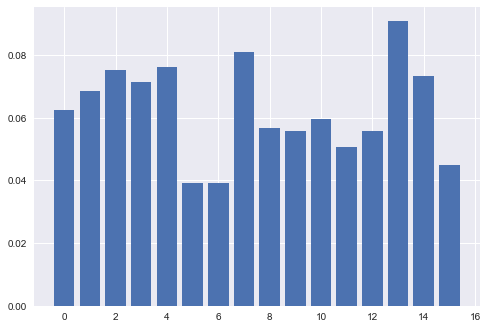

In [56]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()

In [ ]:
13 = 1101

In [ ]:
1100 = 12

-------------